# Loan Prediction Based on Customer Behavior - EDA

# 라이브러리 호출

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import chi2_contingency

# 데이터 불러오기

In [2]:
train = pd.read_csv('/Users/hanhyeongu/Desktop/codestates/project/Section2/Loan prediction/Training Data.csv')
test = pd.read_csv('/Users/hanhyeongu/Desktop/codestates/project/Section2/Loan prediction/Test Data.csv')

In [3]:
train.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


# EDA

### 결측치 확인

In [4]:
# 결측치 존재 여부 확인
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

In [5]:
missing_col = check_missing_col(train)
missing_col = check_missing_col(test)
## train, test 둘다 결측치는 존재하지 않는다!

결측치가 존재하지 않습니다
결측치가 존재하지 않습니다


## feature 타입 분리

In [6]:
categorical = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
quantitative = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

print('카테고리형(정성적) columns : {0} 개'.format(len(categorical)))
print('수치형(정량적) columns : {0} 개'.format(len(quantitative)))

카테고리형(정성적) columns : 6 개
수치형(정량적) columns : 5 개


### 범주형 데이터 탐색

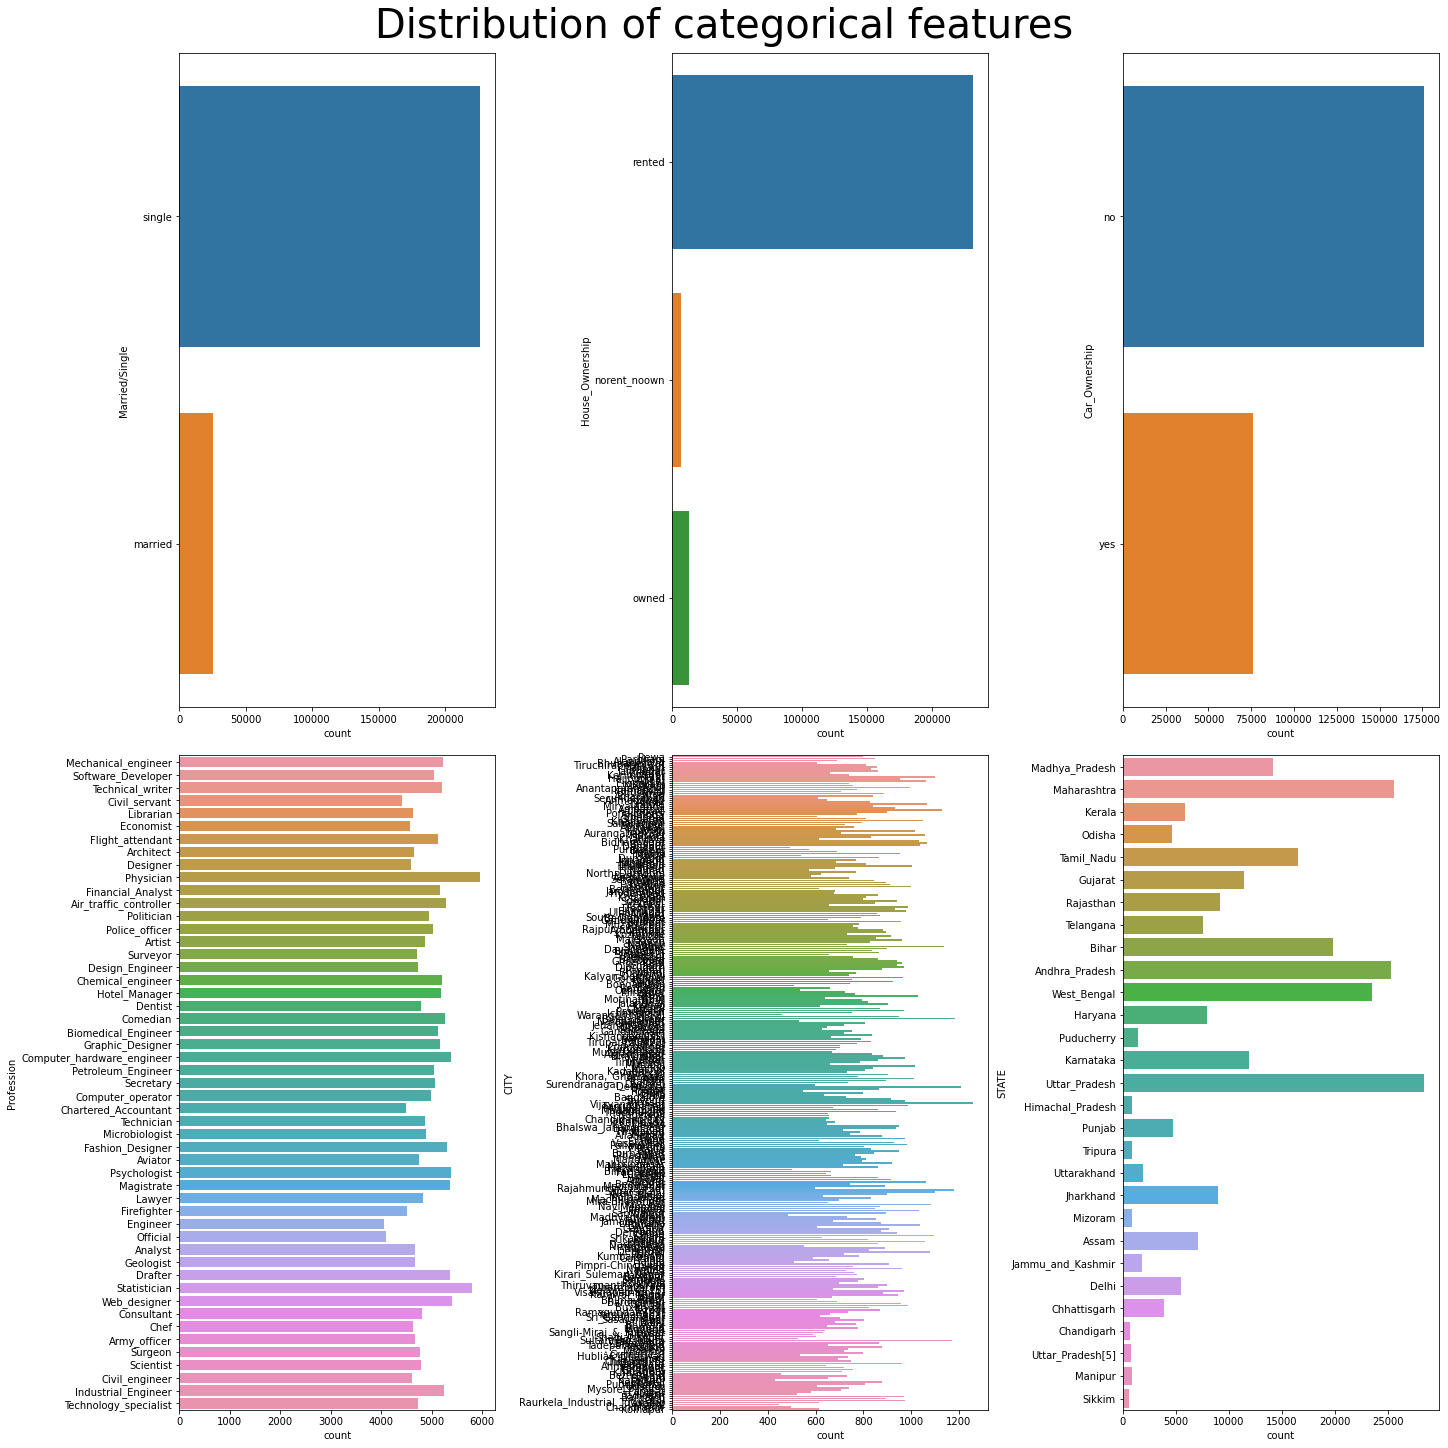

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20,20), constrained_layout=True)
fig.suptitle('Distribution of categorical features', fontsize=40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, y = feature, ax=ax)
plt.show()

위의 그래프를 통해 알 수 있는 것은,  
- 'CITY'의 카디널리티가 매우 높다는 것을 알 수 있다. 또한 분포 또한 어느 한쪽으로 치우져친 것이 아닌 균등하게 분포. 
- 'Profession'의 컬럼도 카디널리티가 높다는 것을 알 수 있다. 
- 'STATE'의 컬럼 또한 카디널리티가 적지는 않다. 또한 분포가 균등하지 않고 치우쳐져 있는 것을 알 수 있다. 
- 결혼의 유무는 single이 많다는 것을 알 수 있다. 
- 'House_ownership'같은 경우는 3가지로 나뉜다. 참조 사이트: https://m.blog.naver.com/langpia/221348567095
  - rented: 임대, 한국에서 전세, 월세와 같은 것이라 생각. 
  - owned: 자가, 소유를 하고있음을 의미
  - norent_noowned: 임대도아니고, 자가도 아닌 경우. 인도에서는 PG(Paying Guesthouse)와 룸 쉐어가 매우 활성화 되어있다. 아마 이런 유형일 것이라 생각.
- 대부분의 사람들이 차는 소유하지 않은 것을 알 수 있다. 

### 수치형 데이터 탐색

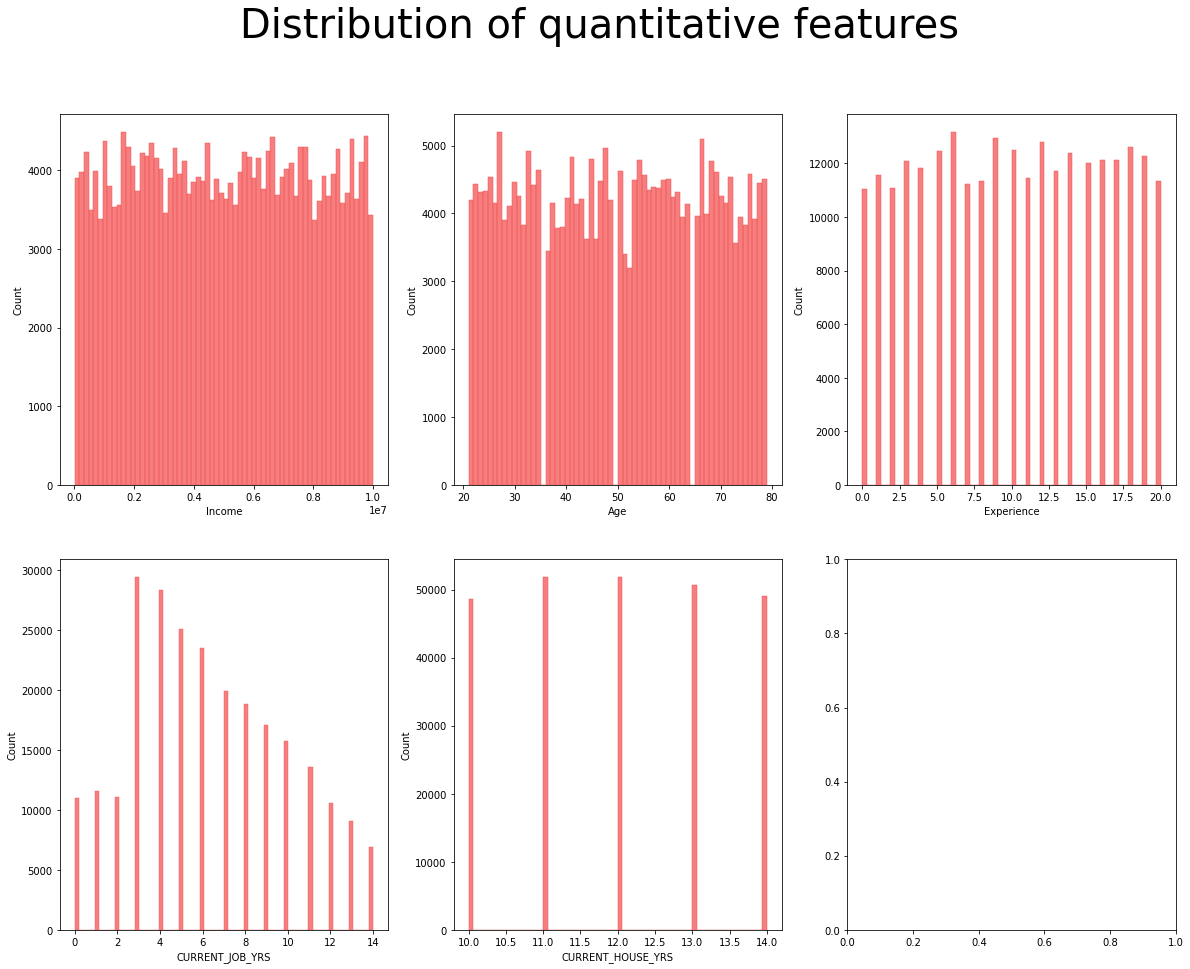

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

위의 그래프를 통해 알 수 있는 것은,  
- 수치형 데이터 대부분은 균등하게 분포되어 있다. 
- 'CURRENT_JOB_YRS' (현재 직장에서 다년간의 경험)의 컬럼은 3~5년이 가장 많은 것을 알 수 있다.

### 이상치 찾기

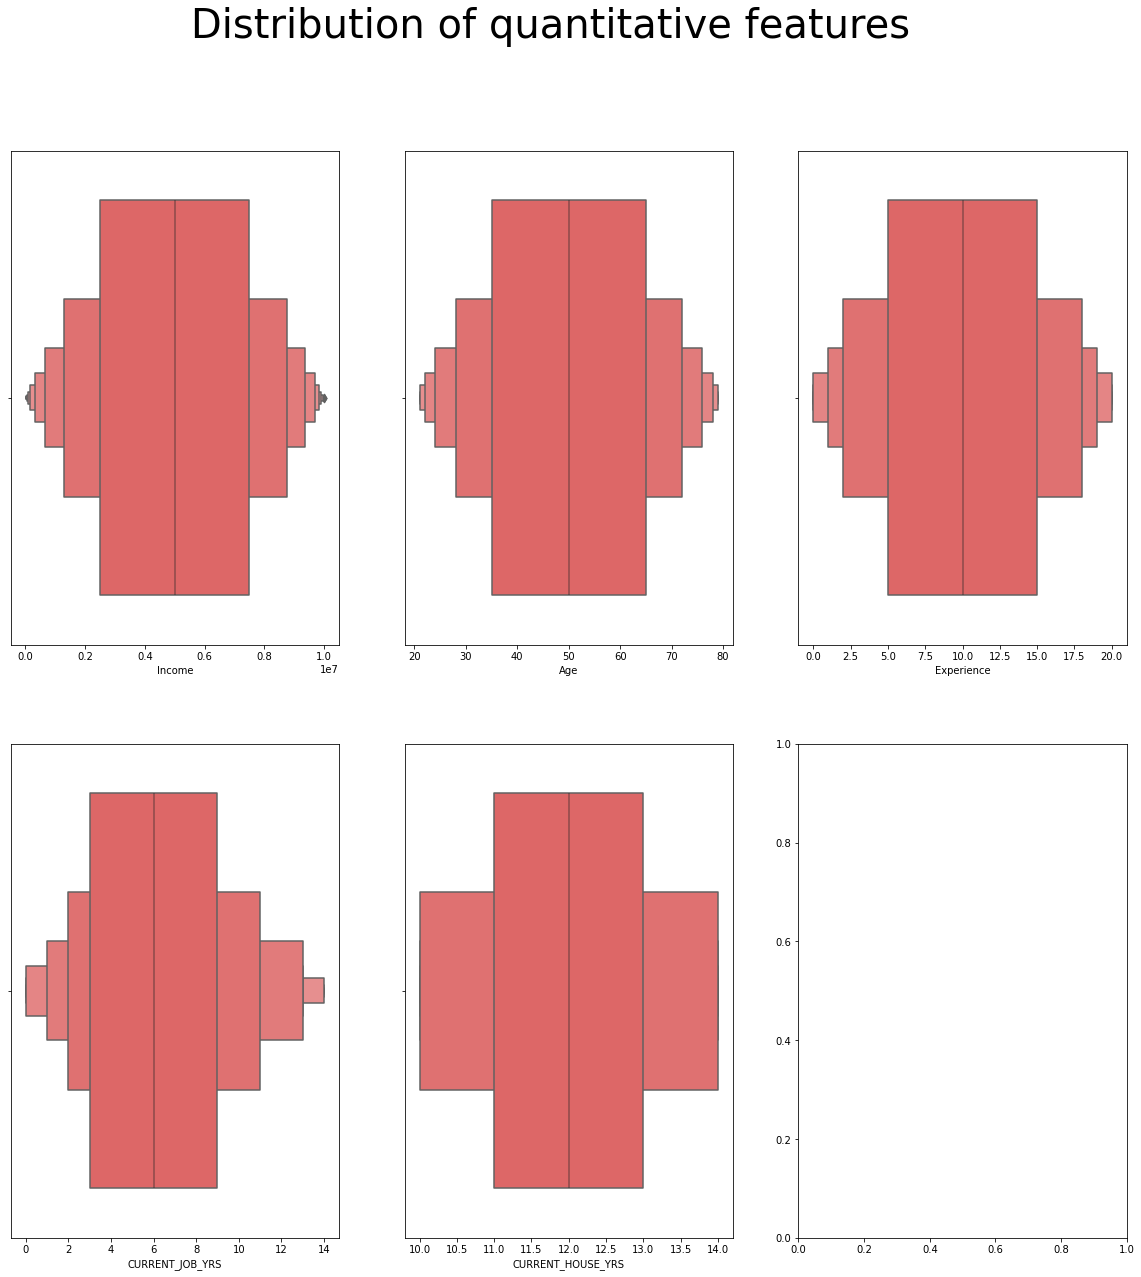

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.boxenplot(data = train, x = feature, ax=ax, color='#f15354')
plt.show()

IQR을 이용하여 이상치의 최대 제한선을 구하고 그 사이 범위를 구해보자

In [10]:
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return lower_bound, upper_bound

outliers = train[quantitative].apply(lambda column: IQR(column))
print('Range of outliers by method')
outliers

Range of outliers by method


,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,-4958715.5,-10.0,-10.0,-6.0,8.0
1,14939232.5,110.0,30.0,18.0,16.0


범위를 뛰어넘는 값들을 구해보자

In [11]:
def IQRsum(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return ((column < lower_bound) | (column > upper_bound)).sum()

outliers = train[quantitative].apply(lambda column: IQRsum(column))
print('Number of outliers by method')
outliers

Number of outliers by method


Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64

그 결과, 이상치는 존재하지 않는 것으로 판단.

### 상관관계 분석

피어슨 상관관계 분석으로 feature들 간의 상관관계를 히트맵을 그려 어떤 컬럼들이 높은 상관관계를 갖는지 알아보자

/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_41268/1260526909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])


Text(0.5, 1.0, 'Correlation between quantitative features')

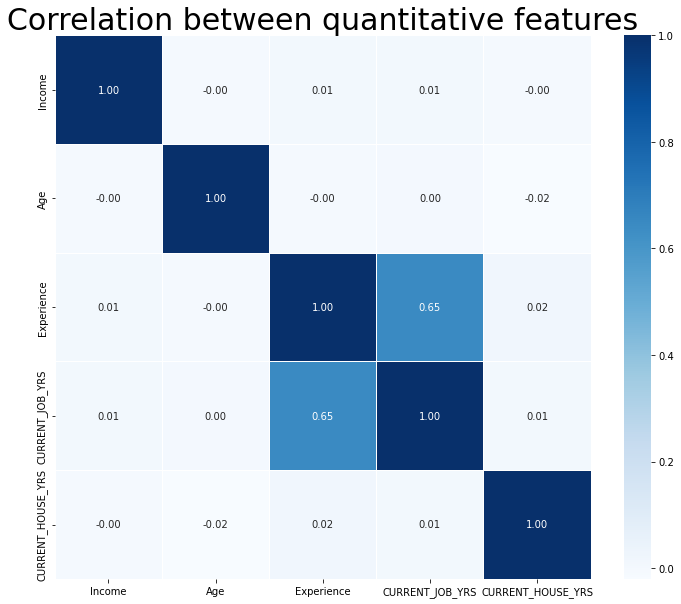

In [12]:
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train[quantitative]
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between quantitative features', fontsize=30)

'Experience'와 'CURRENT_JOB_YRS'는 강한 상관관계가 있는 것을 알 수 있다.  
두 변수간의 상관관계가 높으니 PCA를 통해 하나의 컬럼으로 표현할 수 있을 것 같다. 

In [13]:
condition = (train['CURRENT_JOB_YRS'] > train['Experience'])
train[condition]
# 'CURRENT_JOB_YRS'의 값이 'Experience'보다 높은 관측치가 없음 

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag


## Target의 비율 확인(Risk_Falg)

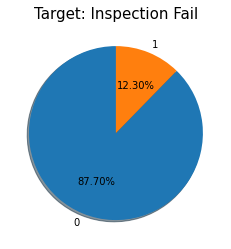

In [15]:
n_zero_label, n_one_label = -1, -1

target = 'Risk_Flag'
label = train[target].value_counts()
n_zero_label = label[0]
n_one_label = label[1]
plt.pie(
    (n_zero_label, n_one_label),
    labels=(0,1),
    autopct="%.2f%%",
    shadow=True,
    startangle=90, 
)
plt.title("Target: Inspection Fail", size=15)
plt.show()

타겟이 불균형이 있어보인다.  

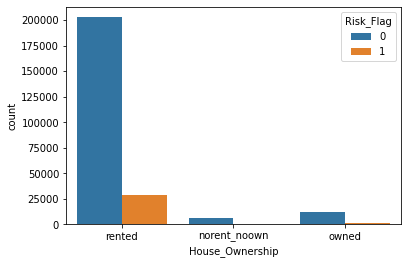

In [89]:
sns.countplot(x='House_Ownership', hue='Risk_Flag', data=train)
plt.show()

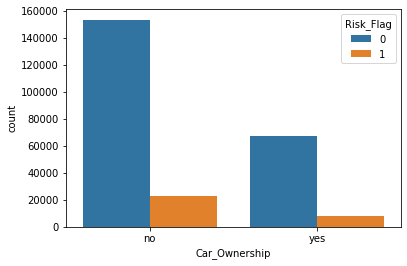

In [90]:
sns.countplot(x='Car_Ownership', hue='Risk_Flag', data=train)
plt.show()

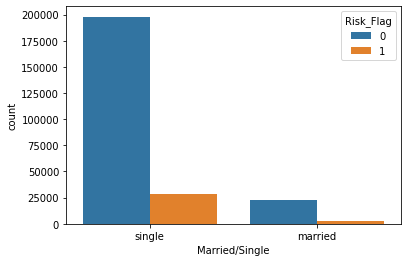

In [91]:
sns.countplot(x='Married/Single', hue='Risk_Flag', data=train)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Income', ylabel='Density'>

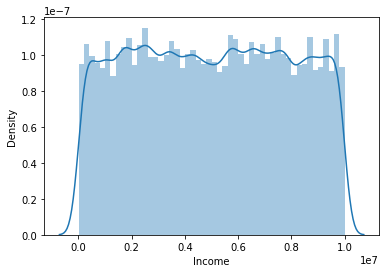

In [93]:
sns.distplot(a=train["Income"])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

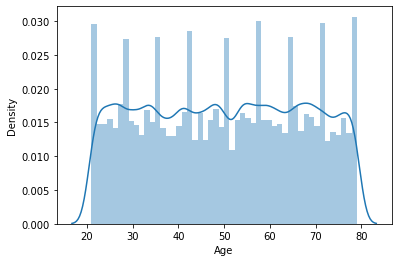

In [94]:
sns.distplot(a=train["Age"])

'House_Ownership', 'Car_Ownership', 'Married/Single'는 One-Hot encoding을 해도 될 것 같다. (카테고리 수가 많지 않으므로)  

'Income', 'Age'는 sclae이 필요해 보인다.  

범주형 컬럼들과 타겟간의 chi-squared 검정을 통해 관계를 파악해보자.  

In [96]:
def chi_square_test(data):
    stat, p, dof, expected = chi2_contingency(data)
    
    # 유의 수준 0.05에서 검정 
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('타겟과 컬럼 간 연관성이 있음  (H0 기각)')
    else:
        print('타겟과 컬럼 간 연관성이 없음 (H0 기각하지 못함(채택))')


#### 'Car_Ownership' - 'Risk_Flag'

In [98]:
car_ownership_risk_flag = pd.crosstab(train["Car_Ownership"], train["Risk_Flag"])
car_ownership_risk_flag

Risk_Flag,0,1
Car_Ownership,,
no,153439,22561
yes,67565,8435


In [99]:
chi_square_test(car_ownership_risk_flag)

p value is 1.7350853850183746e-33
타겟과 컬럼 간 연관성이 있음  (H0 기각)


#### 'Married/Single' - 'Risk_Flag'

In [101]:
marital_status_risk_flag = pd.crosstab(train["Married/Single"], train["Risk_Flag"])
marital_status_risk_flag

Risk_Flag,0,1
Married/Single,,
married,23092,2636
single,197912,28360


In [102]:
chi_square_test(marital_status_risk_flag)

p value is 3.773053705715196e-26
타겟과 컬럼 간 연관성이 있음  (H0 기각)


#### 'House_Ownership' - 'Risk_Flag'

In [103]:
house_ownership_risk_flag = pd.crosstab(train["House_Ownership"], train["Risk_Flag"])
house_ownership_risk_flag

Risk_Flag,0,1
House_Ownership,,
norent_noown,6469,715
owned,11758,1160
rented,202777,29121


In [104]:
chi_square_test(house_ownership_risk_flag)

p value is 1.8381930028370595e-40
타겟과 컬럼 간 연관성이 있음  (H0 기각)
